In [99]:
%load_ext autoreload

%autoreload 2
import matplotlib.pyplot as plt
import pickle
import emcee
from astropy.coordinates import SkyCoord, match_coordinates_3d, match_coordinates_sky
import sys
import numpy as np
from astropy.table import Table, QTable, hstack, vstack
import iminuit
from iminuit import Minuit
import corner

#module from my personnal github
sys.path.append('../modules/')
import analysis_Mass_Richness_relation as analysis
import CL_WL_miscentering as mis
import CL_WL_DATAOPS_make_profile as prf
import CL_WL_two_halo_term as twoh
import CL_WL_mass_conversion as utils
import CL_WL_fit_cluster_mass as fit
import CL_Likelihood_for_Mass_richness_relation as mr
import CL_fiducial_mass_richness_relation as fiducial
sys.path.append('/pbs/throng/lsst/users/cpayerne/ClusterLikelihoods/modules/')
import utils as ut

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [100]:
def load(filename, **kwargs):
    with open(filename, 'rb') as fin:
        return pickle.load(fin, **kwargs)

# Load data

In [101]:
profile_true = load('/pbs/throng/lsst/users/cpayerne/CLMassDC2/data/individual_profile_SkySim5000_gal_redMaPPer_cluster_epsilon_shape_true_z.pkl')

In [102]:
Z_bin = analysis.Z_bin
Obs_bin = analysis.Obs_bin

# Fit WL mass

## Estimating shear profiles & covariances

In [103]:
profile_true_stack = prf.stacked_profile(profile = profile_true,
                    r_in = 'radius_av',
                    gt_in = 'gt_av', gx_in = 'gx_av',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'norm_sum',
                    z_name = 'cluster_z', obs_name = 'richness',
                    Z_bin = Z_bin, Obs_bin = Obs_bin)
covariance_true_stack = prf.bootstrap_covariance(profile = profile_true,
                    r_in = 'radius_av',
                    gt_in = 'gt_av', gx_in = 'gx_av',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'norm_sum',
                    n_boot = 100,
                    z_name = 'cluster_z', obs_name = 'richness',
                    Z_bin = Z_bin, Obs_bin = Obs_bin)

/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/numpy/ma/core.py:2832: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  order=order, subok=True, ndmin=ndmin)


In [104]:
import os
os.environ['CLMM_MODELING_BACKEND'] = 'nc'
import clmm
from clmm import Cosmology
from astropy.table import Table, QTable, hstack, vstack
import pyccl as ccl
from astropy.cosmology import FlatLambdaCDM
cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo_clmm = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo_ccl  = ccl.Cosmology(Omega_c=0.265-0.0448, Omega_b=0.0448, h=0.71, A_s=2.1e-9, n_s=0.96, Neff=0, Omega_g=0)
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)

In [105]:
moo=clmm.Modeling(massdef = 'critical', delta_mdef = 200, halo_profile_model = 'nfw')
moo.set_cosmo(cosmo_clmm)

In [106]:
def mh(richness, z,logm0, G, F):
    return 10**logm0*((1 + z)/(1 + .4))**G*((1 + richness)/(1 + 25))**F

In [119]:
def ds(r, m, c, z):
    moo.set_mass(m), moo.set_concentration(c)
    y=moo.eval_excess_surface_density([float(r[i]) for i in range(len(r))], z)
    return y

In [120]:
def lnlikelihood(theta):
    logm0,G,F=theta
    chi2=0
    for n, halo in enumerate(profile_true_stack):
        m = mh(halo['obs_mean'], halo['z_mean'],logm0, G, F)
        mask = (halo['radius'] > 1)*(halo['radius'] < 5)
        y=ds(halo['radius'], m, , halo['z_mean'])
        chi2=chi2+.5*np.sum(((y-halo['gt'])**2/covariance_true_stack[n]['cov_t'].diagonal())[mask])
    return -chi2

In [121]:
print(lnlikelihood([14,0,1]))

-210.8655500055023


In [123]:
from multiprocessing import Pool
nwalker=100
pos=np.random.randn(nwalker,3) + np.array([14,0,1])
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalker, 3, lnlikelihood,pool=pool)
    sampler.run_mcmc(pos, 100, progress=True);

100%|██████████| 100/100 [00:09<00:00, 11.01it/s]


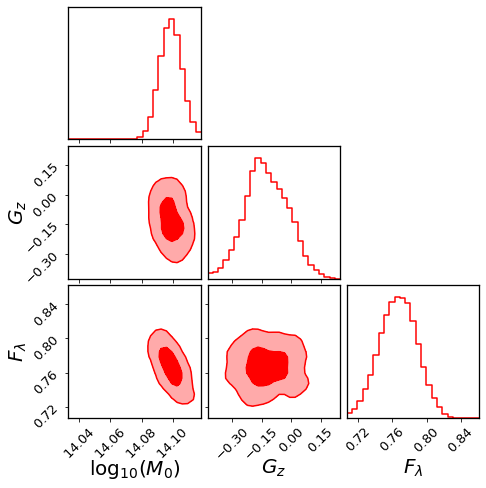

In [124]:
flat_samples = sampler.get_chain(discard=50, thin=3, flat=True)
plt.rcParams['axes.linewidth'] = 1.3
sigma1 = 1. - np.exp(-(1./1.)**2/2.)
sigma2 = 1. - np.exp(-(2./1.)**2/2.)
sigma3 = 1. - np.exp(-(3./1.)**2/2.)
truth = [14.162, -0.23, 0.8]
bins = 25
labels = [r'$\log_{10}(M_{0})$', r'$G_z$',r'$F_\lambda$']
c = ['salmon','m','k','orange','cyan']
fill_contours = [False, False, False,False,  True]
fig, axs = plt.subplots(len(labels), len(labels), figsize = (7,7))

fig = corner.corner(
flat_samples,
bins=bins, levels=(sigma1, sigma2),
fig = fig,
color = 'r',
smooth1d=True,smooth=True,plot_datapoints=False,
fill_contours=True, labels = labels,            
label_kwargs={"fontsize": 20},
use_math_text=True,
show_title = True,
plot_density=False,
max_n_ticks = 5);
    
for i in range(len(labels)):
    for j in range(len(labels)):
        axs[i,j].tick_params(axis='both', which = 'major', labelsize= 13)
        axs[i,j].legend(frameon = False, fontsize = 15)

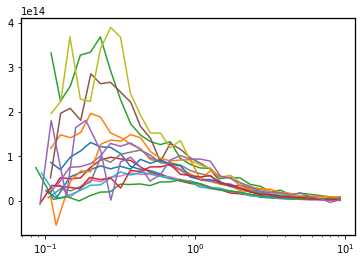

In [83]:
for n, halo in enumerate(profile_true_stack):
    plt.plot(halo['radius'], halo['gt'])
    plt.plot(halo['radius'], halo['gt'])
plt.xscale('log')